# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На вход подаются исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак
Price — цена (евро)

## Подготовка данных

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline

STATE = 12345

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.shape

(354369, 16)

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


На что стоит обратить внимание при дальнейшей предобработке: 

В признаке цены есть нулевые значения

В годе регистрации есть минимальное значение в 1000, а максимальное 9999 - явные выбросы

50, 75 и максимальное значение в пробеге- 150000. Почти вся выборка из одинаковых пробегах. Возможно было при вводе данных ограничение в это значение

NumberOfPictures пустой

Индекс скорее всего признак не влияющий на цену

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

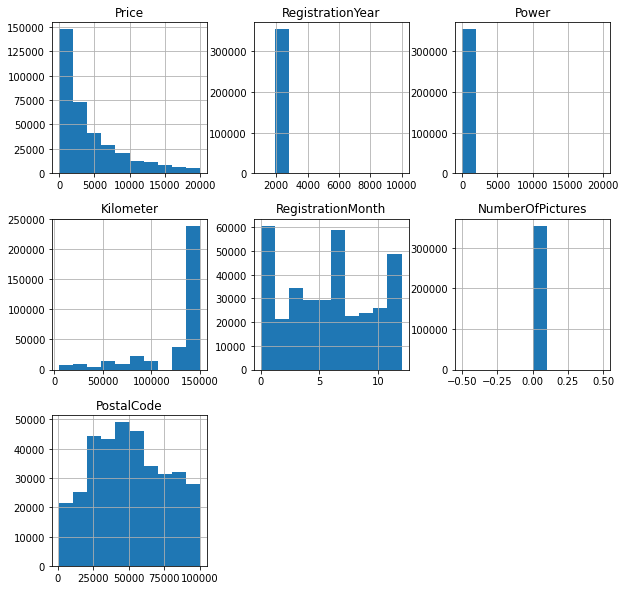

In [8]:
data.hist(figsize=(10,10)); # посмотрим есть ли аномальные значения числовых признаках

В RegistrationYear, Power явно наблюдаются выбросы

Признак Kilometer - достигает максимальных значений около 150'000 - вполне правдоподобно. Но таких значений больше всего

В остальных признаках все в порядке

In [9]:
(data['NumberOfPictures'] == 0).sum()

354369

Подтвердили, что признак заполнен нулями

In [10]:
correlation_matrix= data.corr()

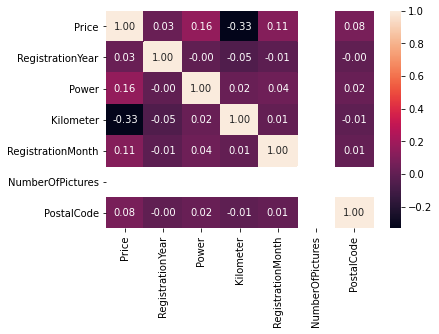

In [11]:
sns.heatmap(correlation_matrix, annot=True, fmt=".2f");

In [12]:
data_phik = data.drop(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures'], axis=1)

interval columns not set, guessing: ['Price']


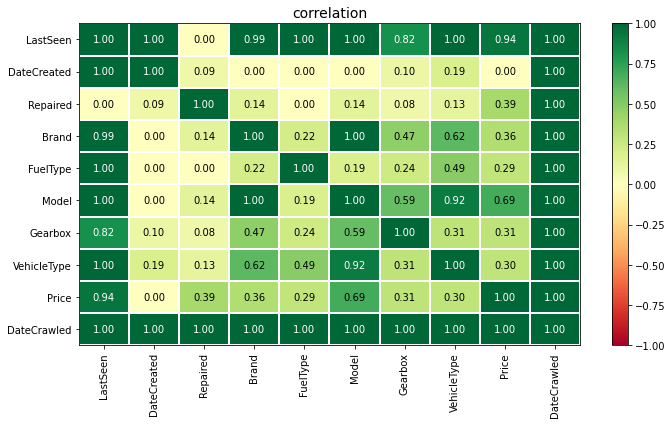

In [13]:
data_phik = data_phik.sample(1000).phik_matrix()

plot_correlation_matrix(data_phik.values, x_labels=data_phik.columns,y_labels=data_phik.index, figsize=(10, 6))

Из числовых признаков практически не коррелирует с целевым Postal Code и RegistrationMonth. Для облегчения задачи обучения модели можно эти признаки не брать. И признак NumberOfPictures не берем.

Остальные признаки и коррелируют и по логике влияют на цену (Пробег, мощность авто, дата регистрации авто)

Посмотрим на категориальные данные

In [14]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


    DateCrawled — дата скачивания анкеты из базы - никак не влияет на цену
    VehicleType — тип автомобильного кузова - значимый признак
    Gearbox — тип коробки передач. Наличие или механической или автоматической коробки влияет на цену
    Model — модель автомобиля,
    Brand — марка автомобиля - оба признака значительно влияют на цену
    FuelType — тип топлива. Дизельный или безиновый двигатель по практике имеет значение на цену авто
    Repaired — была машина в ремонте или нет. Значимый признак. Наличие ремонта снижает цену 
    DateCreated — дата создания анкеты - не влияет на цену
    LastSeen — дата последней активности пользователя не влияет на цену

Оставим в датафрейме только нужные признаки:

In [15]:
data = data[['Price',
            'VehicleType', 
            'RegistrationYear',
            'Gearbox', 
            'Power',
            'Model',
            'Kilometer',
            'FuelType',
            'Brand',
            'Repaired',
            ]]

Посмотрим наличие дубликатов:

In [16]:
data.duplicated().sum()

45040

In [17]:
data = data.drop_duplicates()

Посмотрю на гистограмму с годом с максимальным текущим годом, для определения объективной нижней границы ( и без учета явно аномальных значений, например до 1940 года)

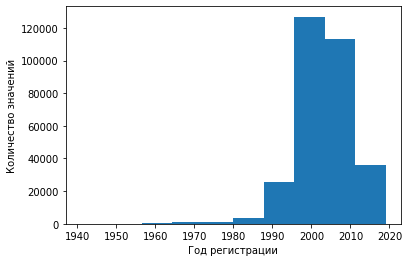

In [18]:
data[(data['RegistrationYear'] < 2024) & (data['RegistrationYear'] > 1940)]['RegistrationYear'].plot(kind='hist');

plt.xlabel('Год регистрации')
plt.ylabel('Количество значений')
plt.show()

In [19]:
data[(data['RegistrationYear'] > 2024) | (data['RegistrationYear'] < 1970)].head()

# год регистрации не может быть больше текущего, а меньше 1970 - аномалии

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
630,12000,sedan,1969,manual,140,s_klasse,80000,petrol,mercedes_benz,no
1794,12800,coupe,1965,manual,90,other,100000,petrol,ford,no
1928,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no


In [20]:
((data['RegistrationYear'] > 2024) | (data['RegistrationYear'] < 1970)).sum() / data.shape[0] * 100

0.4428941353704309

Данных меньше пяти сотых процента, удалим

In [21]:
data = data[(data['RegistrationYear'] <= 2024) & (data['RegistrationYear'] >= 1970)]

In [22]:
(data['RegistrationYear'] > 2024).sum()

0

In [23]:
data[data['Power'] > 400] # мощность авто выше 300 лс аномальное значение, что подтверждает беглый просмотр данных

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
2781,19500,suv,2004,auto,450,cayenne,125000,petrol,porsche,no
3289,16899,wagon,2003,auto,476,e_klasse,150000,petrol,mercedes_benz,no
3746,0,NaN,2017,manual,750,NaN,150000,petrol,smart,no
...,...,...,...,...,...,...,...,...,...,...
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
352322,15999,wagon,2007,auto,435,other,150000,petrol,audi,no
353493,12500,NaN,2017,manual,2000,other,60000,gasoline,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [24]:
(data['Power'] > 400).sum() / data.shape[0] * 100

0.22373108108546919

Таких данных около двух десятых процента- удалим

In [25]:
data[data['Power'] < 20]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


In [26]:
data = data[(data['Power'] < 400) & (data['Power'] > 20)]

In [27]:
(data['Power'] > 400).sum()

0

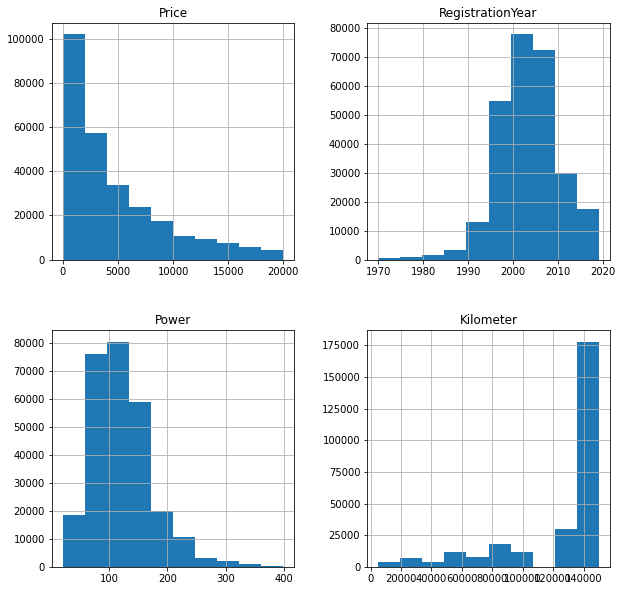

In [28]:
data.hist(figsize=(10,10));

In [29]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


Посмотрим на целевой признак

In [30]:
data['Price'].describe()

count    271482.000000
mean       4766.149737
std        4621.881107
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64

Есть и нулевые значения и значения (около 25%, которые ниже 1010 евро). Я бы оставил порог в 500 евро- по цене ниже купить авто вряд ли получится. И стоит посмотреть и на верхнюю границу- авто с ценой от 6350 до 20000

In [31]:
data.query('Price < 500')


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
23,450,small,1997,manual,50,arosa,150000,petrol,seat,no
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
...,...,...,...,...,...,...,...,...,...,...
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354293,480,sedan,1996,manual,136,c_klasse,150000,petrol,mercedes_benz,NaN
354297,400,wagon,1996,manual,150,a4,150000,petrol,audi,NaN
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


Таких данных около 10%. Но в связи с их неинформотивностью по целевому признаку, считаю лучше не брать их в рассчет

In [32]:
data = data.query('Price > 500')

In [33]:
data.query('Price < 500').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [34]:
data.query('Price > 19000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
484,19900,bus,2009,manual,150,viano,90000,gasoline,mercedes_benz,no
1360,19850,sedan,2013,auto,150,golf,60000,gasoline,volkswagen,no
1515,20000,sedan,2010,auto,239,a6,150000,gasoline,audi,no
1586,20000,sedan,2014,auto,184,leon,40000,gasoline,seat,no
...,...,...,...,...,...,...,...,...,...,...
353096,19900,sedan,2010,auto,204,e_klasse,80000,gasoline,mercedes_benz,no
353193,19500,bus,1970,auto,69,transporter,30000,petrol,volkswagen,NaN
353590,19950,wagon,2009,manual,265,other,125000,petrol,audi,no
354178,19990,small,2014,auto,185,a1,10000,petrol,audi,no


Цена в 20000 евро в датасете максимальная. Но на рынке явно есть авто и с большей стоимостью, вероятно при вводе данных было какое то ограничение. Верхнюю границу считаю трогать не стоит

In [35]:
data['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'seat', 'subaru',
       'volvo', 'mitsubishi', 'alfa_romeo', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

In [36]:
data[data['Brand'] == 'sonstige_autos'].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
661,9900,suv,2000,auto,250,NaN,150000,lpg,sonstige_autos,no
700,6999,sedan,2010,auto,186,NaN,125000,petrol,sonstige_autos,no
1098,11500,bus,1985,auto,160,NaN,125000,petrol,sonstige_autos,NaN
1106,9200,sedan,2005,auto,249,NaN,150000,petrol,sonstige_autos,no
1274,16990,small,2015,manual,135,NaN,20000,petrol,sonstige_autos,no


Объединенные бренды авто, c немецкого sonstige = другой

Проверим пропуски в данных

In [37]:
data.isna().sum()

Price                   0
VehicleType         16771
RegistrationYear        0
Gearbox              4754
Power                   0
Model                9854
Kilometer               0
FuelType            15548
Brand                   0
Repaired            36491
dtype: int64

Есть пропуски в признаках VehicleType, Gearbox, Model, FuelType, Repaired. Изучим и попробуем по возможности их заполнить

Все эти признаки категориальные и заполнить средним(медианой) тут не получится

Долго думал, чем можно заполнить пропуски в признках с типом кузова и в итоге понял, что даже если написать функцию по самым распространенным типам кузова по бренду- это будет не совсем корректно. Надо учитывать и модель и бренд и все равно это будет угадыванием (у одной и той же модели и бренда авто могут быть 2 и 3 вариации)
Модель авто по косвенным признакам тоже не угадать

Так же угадать какая коробка и был ли автомобиль в ремонте невозможно. 

Варинт либо использовать какие-то модели ML, которые по имеющимся признакам смогут подставить значения (Но в данном исследовании стоит другая задача, а разаработь такие модели - это достаточно затратные по времеи операции)

Думаю самый правильный и оптимальный вариант в данном случае- проверить, если, например, в строке пропусков более 2 (или 3) - удалить эти строки из-за небольшой информативности

In [38]:
data.shape

(246027, 10)

Посмотрим на признаки, которые сильно коррелируют с целевым, и если в них будут пропуски- думаю их можно удалить. Остальные признаки заполним каким-нибудь средним значением

Построю еще одну матрицу корреляций, только по признакам с пропусками

interval columns not set, guessing: ['Price']


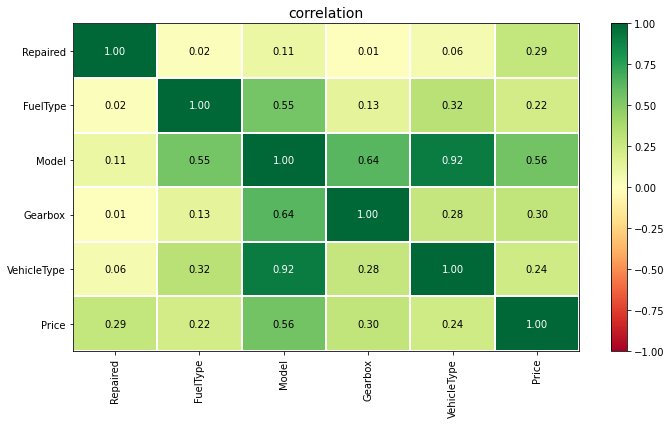

In [39]:
data_phik2 = (data[['Price','VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']]
              .phik_matrix())

(plot_correlation_matrix(data_phik2.values, 
                         x_labels=data_phik2.columns, 
                         y_labels=data_phik2.index, 
                         figsize=(10, 6)))

По проведенному анализу корреляции значимый признак: Model

Удалю из выборки строки, в которых в признаке Model пропуски и еще более чем в 2 признаках имеются пропуски

In [40]:
data[(data.isna().sum(axis=1) > 2) & data['Model'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
161,1495,wagon,2001,NaN,64,NaN,150000,gasoline,volkswagen,NaN
186,14000,sedan,2008,NaN,235,NaN,150000,NaN,bmw,no
435,1300,NaN,2017,manual,150,NaN,150000,NaN,volkswagen,no
1060,1800,NaN,2018,manual,136,NaN,150000,NaN,fiat,no
1172,4600,NaN,2017,manual,131,NaN,150000,NaN,audi,NaN
...,...,...,...,...,...,...,...,...,...,...
353769,650,NaN,2000,manual,150,NaN,150000,NaN,audi,no
353816,9800,small,2013,manual,90,NaN,50000,NaN,renault,NaN
354007,10980,NaN,2018,manual,75,NaN,20000,NaN,volkswagen,no
354011,1000,NaN,2017,manual,54,NaN,125000,NaN,hyundai,no


In [41]:
data = data[(data.isna().sum(axis=1) <= 2) & (data['Model'] != 'NaN')]

In [42]:
data.isna().sum()

Price                   0
VehicleType         12236
RegistrationYear        0
Gearbox              3179
Power                   0
Model                7373
Kilometer               0
FuelType            11228
Brand                   0
Repaired            31951
dtype: int64

In [43]:
data['FuelType'].value_counts(dropna=False)

petrol      148588
gasoline     75838
NaN          11228
lpg           4223
cng            441
hybrid         191
other           65
electric        37
Name: FuelType, dtype: int64

Так как в petrol  больше всего значений, предположу, что в тех данных, где не заполнены данные, тоже бензиновый тип топлива

In [44]:
data['FuelType'].fillna('petrol', inplace=True)

In [45]:
data['Repaired'].value_counts(dropna=False)

no     188303
NaN     31951
yes     20357
Name: Repaired, dtype: int64

Так же предположу, что там, где данные не заполнены- авто не было в ремонте

In [46]:
data['Repaired'].fillna('no', inplace=True)

In [47]:
data['Gearbox'].value_counts(dropna=False)

manual    186301
auto       51131
NaN         3179
Name: Gearbox, dtype: int64

Заполню пропуски значениями с механической коробкой

In [48]:
data['Gearbox'].fillna('manual', inplace=True)

In [49]:
data['Model'].value_counts(dropna=False)

golf                  18910
other                 17408
3er                   14187
NaN                    7373
polo                   7269
                      ...  
kalina                    4
rangerover                3
samara                    3
serie_3                   3
range_rover_evoque        1
Name: Model, Length: 250, dtype: int64

С моделью не угадать, заполню значеним unknown.

In [50]:
data['Model'].fillna('unknown', inplace=True)

In [51]:
data['VehicleType'].value_counts(dropna=False)

sedan          66516
small          50610
wagon          48013
bus            22892
convertible    16374
coupe          12303
NaN            12236
suv             9626
other           2041
Name: VehicleType, dtype: int64

sedan, small, wagon - наиболее встречающиеся значения, заполнить пропуски каким-то из этих значений не очень корректно, так же заполню пропуски unknown

In [52]:
data['VehicleType'].fillna('unknown', inplace=True)

In [53]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Подготовка данных завершена, следующий этап- кодировка признаков


## Обучение моделей

Для обучения я буду использовать DummyRegressor, LinearRegressor, RandomForestRegressor, LightGBM, Catboost

In [54]:
X = data.drop(['Price'], axis=1)
y = data['Price']

Так как по условию нужно 1 итоговую модель проверить на тестовой выборке разделим датасет на 3 части:

In [55]:
x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.20, random_state=STATE)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=STATE)

In [56]:
print(f'Количество тренировочных признаков: {x_train.shape[0]}, доля {x_train.shape[0]/X.shape[0]:.2f}')
print(f'Количество тренировочных целей: {y_train.shape[0]}, доля {y_train.shape[0]/X.shape[0]:.2f}')
print(f'Количество валидационных признаков: {x_valid.shape[0]}, доля {x_valid.shape[0]/X.shape[0]:.2f}')
print(f'Количество валидационных целей: {y_valid.shape[0]}, доля {y_valid.shape[0]/X.shape[0]:.2f}')
print(f'Количество тестовых признаков: {x_test.shape[0]}, доля {x_test.shape[0]/X.shape[0]:.2f}')
print(f'Количество тестовых целей: {y_test.shape[0]}, доля {y_test.shape[0]/X.shape[0]:.2f}')


Количество тренировочных признаков: 153990, доля 0.64
Количество тренировочных целей: 153990, доля 0.64
Количество валидационных признаков: 48123, доля 0.20
Количество валидационных целей: 48123, доля 0.20
Количество тестовых признаков: 38498, доля 0.16
Количество тестовых целей: 38498, доля 0.16


Для начала определим Baseline с помощью Дамми

In [57]:
dummy = DummyRegressor()

In [58]:
%time dummy.fit(x_train, y_train)

CPU times: user 831 µs, sys: 51 µs, total: 882 µs
Wall time: 634 µs


DummyRegressor()

In [59]:
%time dummy_predict = dummy.predict(x_valid)

CPU times: user 578 µs, sys: 0 ns, total: 578 µs
Wall time: 363 µs


In [60]:
rmse_dummy = int(mean_squared_error(y_valid, dummy_predict, squared=False))
print(f'Метрика RMSE на dummy-модели составила {rmse_dummy} евро.')

Метрика RMSE на dummy-модели составила 4619 евро.


Так как для проверки у нас будет еще несколько моделей буду добавлять результаты в итоговую табличку:

In [61]:
results = pd.DataFrame({'DummyRegressor':['524 µs', '794 µs', '4619']}, index = [['time_fit', 'time_predict', 'RMSE']])
results

,DummyRegressor
time_fit,524 µs
time_predict,794 µs
RMSE,4619


In [62]:
linear_transformer = make_column_transformer(
    (OneHotEncoder(dtype='uint16', handle_unknown='ignore'), 
     make_column_selector(dtype_include='object')
    ),
    (StandardScaler(), 
     make_column_selector(dtype_include='int')
    ),
    remainder='passthrough'
)

In [63]:
linear_pipe = make_pipeline(linear_transformer, LinearRegression())

In [64]:
%time linear_pipe.fit(x_train, y_train)

CPU times: user 10.1 s, sys: 10.8 s, total: 20.9 s
Wall time: 20.9 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(dtype='uint16',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7700a8d60>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7700a8a30>)])),
                ('linearregression', LinearRegression())])

In [65]:
%time linear_predict = linear_pipe.predict(x_valid)

CPU times: user 83.3 ms, sys: 9.38 ms, total: 92.6 ms
Wall time: 214 ms


In [66]:
rmse_linear = int(mean_squared_error(y_valid, linear_predict, squared=False))
print(f'Метрика RMSE на LinearRegression составила {rmse_linear} евро.')

Метрика RMSE на LinearRegression составила 2537 евро.


In [67]:
results['LinearRegression'] = ['16.9 s', '119 ms', '2537']

In [68]:
results

,DummyRegressor,LinearRegression
time_fit,524 µs,16.9 s
time_predict,794 µs,119 ms
RMSE,4619,2537


In [69]:
ensemble_transformer = make_column_transformer(
    (OrdinalEncoder(dtype='uint16', handle_unknown='ignore'), 
     make_column_selector(dtype_include='object')
    ),
    (StandardScaler(), 
     make_column_selector(dtype_include='number')
    ),
        remainder='passthrough'
)

In [70]:
forest_pipe = make_pipeline(
    ensemble_transformer,
    RandomForestRegressor(random_state=STATE)
)

In [71]:
param_forest = {
    'randomforestregressor__max_depth':np.arange(5, 16, 5)
}

grid_forest = GridSearchCV(
    forest_pipe,
    param_forest,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [72]:
%time grid_forest.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 3min 47s, sys: 852 ms, total: 3min 48s
Wall time: 3min 48s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='uint16',
                                                                                        handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff770611790>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff770611d60>)])),
                                       ('ran

In [ ]:
grid_forest.best_params_

In [ ]:
forest_best_pipe = make_pipeline(
    ensemble_transformer,
    RandomForestRegressor(random_state=STATE, max_depth=15)
)

In [ ]:
%time forest_best_pipe.fit(x_train,y_train)

In [ ]:
%time forest_best_predict = forest_best_pipe.predict(x_valid)

In [ ]:
rmse_forest_best = int(mean_squared_error(y_valid, forest_best_predict, squared=False))
print(f'Метрика RMSE на RandomForestRegressor составила {rmse_forest_best} евро.')

In [ ]:
results['RandomForestRegressor'] = ['22.6 s', '774 ms', '1677']

In [ ]:
results

In [ ]:
cat_columns = X.select_dtypes(include='object').columns.tolist()
num_columns = X.select_dtypes(include='int').columns.tolist()

Для LGBM не нужен скалер для числовых признаков, поэтому кодируем только категориальные

In [ ]:
lgbm_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include='object')
    ),
    remainder='passthrough'
)



In [ ]:
df_lgbm = pd.DataFrame(lgbm_transformer.fit_transform(data), 
                       columns=cat_columns+data.select_dtypes(include='int').columns.tolist())

In [ ]:
X_lgbm = df_lgbm.drop(['Price'], axis=1)
y_lgbm = df_lgbm['Price']

X_lgbm, X_lgbm_valid, y_lgbm, y_lgbm_valid = train_test_split(X_lgbm, y_lgbm, test_size= 0.2, random_state=STATE)
X_lgbm, x_lgbm_test, y_lgbm, y_lgbm_test = train_test_split(X_lgbm, y_lgbm, test_size=0.20, random_state=STATE)

In [ ]:
LGBM = LGBMRegressor(
    objective='regression',
    metrics='rmse',
    verbosity=-1,
    random_state=STATE
)

In [ ]:
param_LGBM = {
    'max_depth':[-1, 10, 20],
    'learning_rate':[.1, .5]
}
              
gs_lgbm = GridSearchCV(
    LGBM,
    param_LGBM,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
%time gs_lgbm.fit(X_lgbm, y_lgbm)

In [ ]:
gs_lgbm.best_params_

In [ ]:
LGBM_best = LGBMRegressor(
    objective='regression',
    metrics='rmse',
    verbosity=-1,
    random_state=STATE,
    learning_rate=0.5, 
    max_depth=(-1)
)

In [ ]:
%time LGBM_best.fit(X_lgbm, y_lgbm)

In [ ]:
%time LGBM_predict_best = LGBM_best.predict(X_lgbm_valid)

In [ ]:
rmse_lgbm_best = int(mean_squared_error(y_lgbm_valid, LGBM_predict_best, squared=False))
print(f'Метрика RMSE на LightGBM составила {rmse_lgbm_best} евро.')

In [ ]:
results['LightGBM'] = ['3.03 s', '261 ms', '1653']

In [ ]:
CatBoost = CatBoostRegressor(
    random_seed=STATE,
    early_stopping_rounds=5,
    cat_features=cat_columns,
    logging_level='Silent'
)

In [ ]:
param_grid = {
    'iterations':[200, 250, 300],
    'learning_rate': [.2, .3],
}
              
cat_grid = GridSearchCV(
    CatBoost,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    verbose=4
)

In [ ]:
%time cat_grid.fit(x_train, y_train)

In [ ]:
CatBoost_best = CatBoostRegressor(
    random_seed=STATE,
    early_stopping_rounds=5,
    cat_features=cat_columns,
    logging_level='Silent',
    iterations=300, 
    learning_rate=0.3
)

In [ ]:
%time CatBoost_best.fit(x_train, y_train)

In [ ]:
%time cat_predict_best = CatBoost_best.predict(x_valid)

In [ ]:
rmse_cat_best = int(mean_squared_error(y_valid, cat_predict_best, squared=False))
print(f'Метрика RMSE на CatBoost составила {rmse_cat_best} евро.')

In [ ]:
results['CatBoost'] = ['30.4 s', '151 ms', '1631']

In [ ]:
results

## Анализ моделей

Итак, обучив 5 моделей получили результаты: 

При Baseline в 4619 и необходимом максимальном значении RMSE в 2500, 3 модели першли минимальный порог и перешли в финал: RandomForestRegressor, LightGBM, CatBoost. (LinearRegression чуть-чуть не дотянула до порога)

RandomForest показал чуть лучшую скорость по сравнению с Catboost по времени обучения, но выдал большее значение ошибки. И дольше всех давал предсказания

LGBM показал самый лучший результат по скорости обучения и по метрике и скорости предсказания- 2 место

Catboost дольше всех обучался, но при этом выдал лучший показатель по метрике. По времени предсказаний- 1 место

Технически все 3 модели прошли по условиям выбор наилучшей модели зависит от того, насколько больше важен параметр скорости обучения или качество предсказания

Если делать выбор в пользу скорости - то однозначно LGBM

Если все-таки важны доли процента в разнице метрики- то Catboost.

Я остановлю свой выбор на LGBM, я считаю что разница в показателях метрики не так критичны, а скорость обучения выше на порядок.

Финальным шагом проверим LGBM на тестовой выборке

In [ ]:
LGBM_predict_test = gs_lgbm.predict(x_lgbm_test)

In [ ]:
rmse_lgbm_test = int(mean_squared_error(y_lgbm_test, LGBM_predict_test, squared=False))
print(f'Метрика RMSE на LightGBM на тестовой выборке составила {rmse_lgbm_test} евро.')

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей